# Practice and Example 

DataMarket is a library of datasets, we can download many different datasets to practice, my examples are come from this website. https://datamarket.com/data/list/?q=provider:tsdl

# Autoregressive integrated moving average model

ARIMA is the mixture of Autoregressive (AR) and moving average (MA) model, ARIMA is one of the most common function we use in time series. Um... why I say function, not model?

Because we love simple model, the ARIMA model would be simplified to AR model or MA model.

# Let show you an example!

I inserted a time series dataset from DataMarket which is about Annual Ferry Flow, I assigned a name as data. The most frequent problem in R is wrong data type, I converted the data type to time series (ts), prepared for the time series functions.

In [1]:
# Get data from csv.
data = read.csv("../Annual_flows.csv",header=T)
# Convert data to time series
data.ts = ts(data[2])

# Stationary checking

Before the ARIMA model, we should check the stationary. If that fails, the dataset is explainable, we have to eliminate that. According to the first graph below, we found a reducing trend, difference is needed.

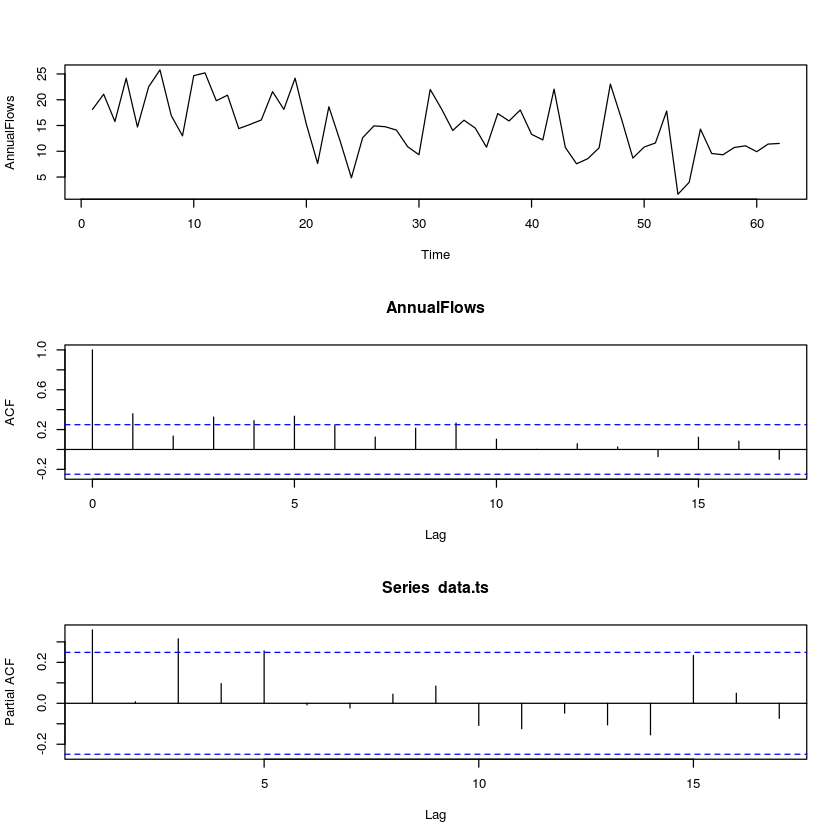

In [2]:
par(mfrow=c(3,1))
plot.ts(data.ts) # Plot the graph of time series
acf(data.ts) # Plot the ACF
acf(data.ts,type="partial") # Plot the PACF

In [3]:
# Log Differencing
dld = diff(log(data.ts))
# Eliminate the mean 
dlmd = dld - mean(dld)

# ACF and PACF

We got the stationary time series now, we could move to the next step 'ACF and PACF'. ACF and PACF help us to select the suitable models.

## AR and ACF

<b>Autoregressive model</b>, it forecasts with the past observations, therefore the time series usually relate with almost all past noises. We might find some pattern in ACF and cut-off pattern in PACF.

## MA and PACF

<b>Moving average model</b>, it forecasts with the past noises, therefore the time series usually relate with several noises only. We might find some pattern in PACF (Partial ACF) and cut-off pattern in ACF.

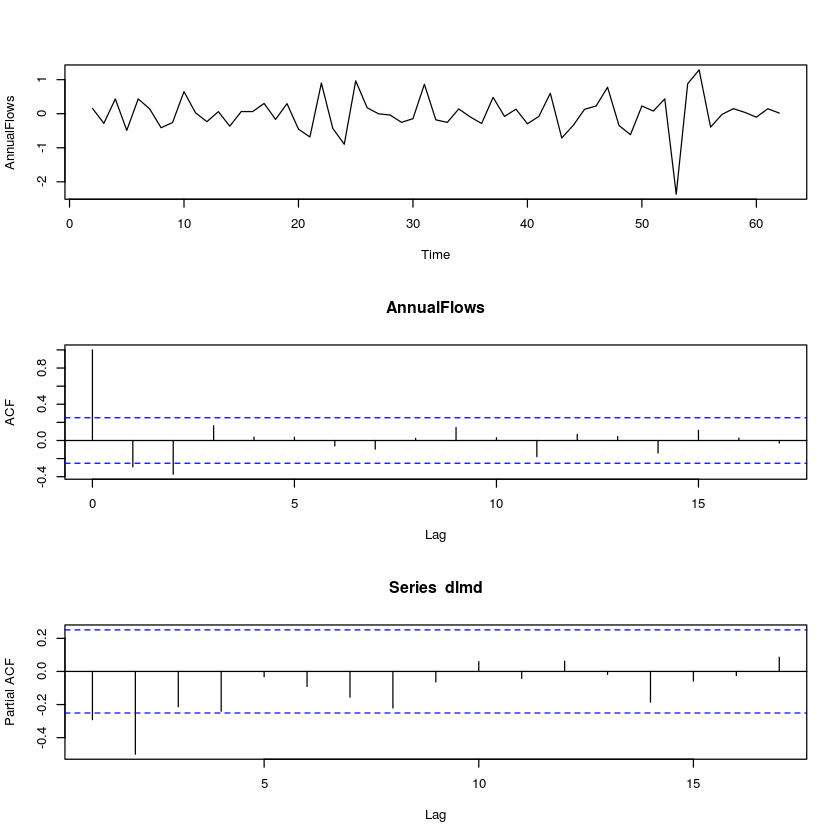

In [4]:
par(mfrow=c(3,1))
plot.ts(dlmd) # Plot the graph of time series
acf(dlmd) # Plot the ACF
acf(dlmd,type="partial") # Plot the PACF

# Selection of ARIMA

According to the ACF and PACF graphs above, ACF was cut off and PACF had a weak pattern. We also found the lag-8 PACF is close with line, therefore we started at MA(8) model.

In [5]:
# Because we removed the mean above, include.mean is False
ma8 = arima(dlmd,order=c(0,0,8),include.mean=F)
print(ma8)


Call:
arima(x = dlmd, order = c(0, 0, 8), include.mean = F)

Coefficients:
          ma1      ma2     ma3      ma4      ma5      ma6     ma7     ma8
      -0.6944  -0.3903  0.3476  -0.0925  -0.1713  -0.1116  0.0261  0.1610
s.e.   0.1276   0.1611  0.1702   0.1875   0.2303   0.1623  0.2164  0.1904

sigma^2 estimated as 0.1531:  log likelihood = -30.65,  aic = 79.29


# Simplify Model

We got the result table above, coefficients ma4-8 are not significant (s.e. > |coef|), we simplified the model to MA(3). 

In [6]:
ma3 = arima(dlmd,order=c(0,0,3),include.mean=F)
print(ma3)


Call:
arima(x = dlmd, order = c(0, 0, 3), include.mean = F)

Coefficients:
          ma1      ma2     ma3
      -0.6719  -0.4659  0.2121
s.e.   0.1239   0.1490  0.1170

sigma^2 estimated as 0.1596:  log likelihood = -31.64,  aic = 71.28


# AIC

AIC is a value which shows how good is the model, a simple and accurate model usually have smaller AIC. Therefore, MA(3) is better than MA(8). However, we found lags-2 are significant in ACF graph too, we had to test the AR side.

In [7]:
arma3 = arima(dlmd,order=c(3,0,3),include.mean=F)
print(arma3)


Call:
arima(x = dlmd, order = c(3, 0, 3), include.mean = F)

Coefficients:
         ar1     ar2     ar3      ma1      ma2     ma3
      0.3531  0.0686  0.1589  -1.0465  -0.2641  0.3331
s.e.  0.6567  0.4933  0.1901   0.6639   0.6593  0.4975

sigma^2 estimated as 0.1577:  log likelihood = -31.35,  aic = 76.71


In [8]:
arma2 = arima(dlmd,order=c(2,0,1),include.mean=F)
print(arma2)


Call:
arima(x = dlmd, order = c(2, 0, 1), include.mean = F)

Coefficients:
         ar1      ar2      ma1
      0.1694  -0.2357  -0.9088
s.e.  0.1396   0.1350   0.0924

sigma^2 estimated as 0.164:  log likelihood = -32.4,  aic = 72.8


In [9]:
arma2a = arima(dlmd,order=c(2,0,1),include.mean=F,fixed=c(0,NA,NA),transform.pars=F)
print(arma2a)


Call:
arima(x = dlmd, order = c(2, 0, 1), include.mean = F, transform.pars = F, fixed = c(0, 
    NA, NA))

Coefficients:
      ar1      ar2      ma1
        0  -0.2993  -0.7763
s.e.    0   0.1504   0.1740

sigma^2 estimated as 0.1686:  log likelihood = -32.98,  aic = 71.96


# Test more and result

After few tests, ARMA(2,1) without ar1 had the smallest AIC, it likes a good model, but we had to test more features.

Ljung-Box is the last test to verify the model, the graph below showed the model pass. Therefore ARMA(2,1) without ar1 is our final model.

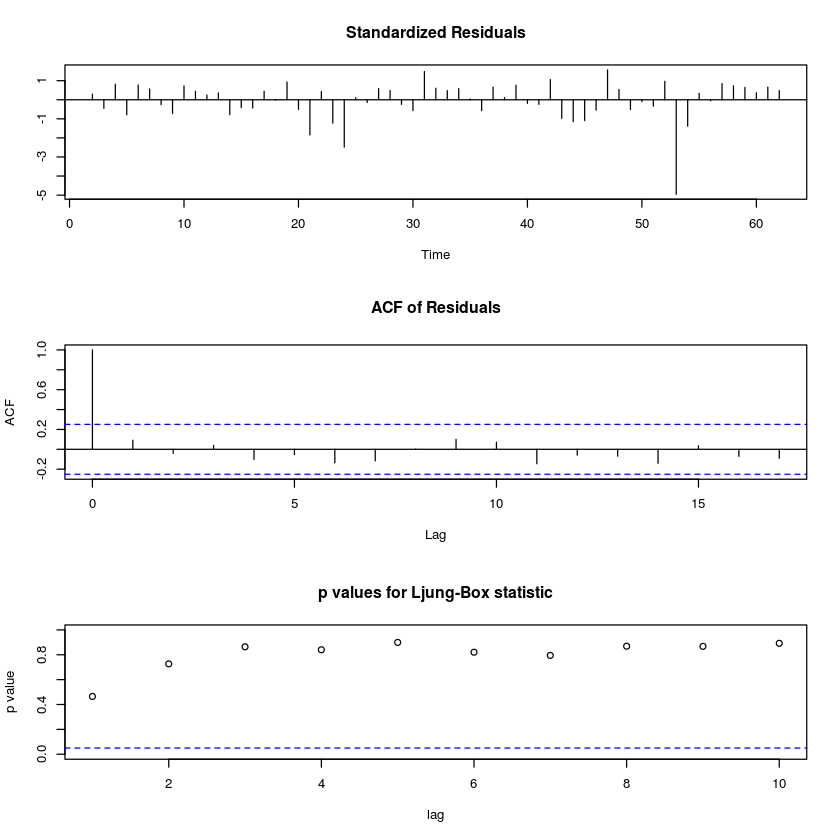

In [10]:
# Final test
tsdiag(arma2a)

# Prediction

Now, we got a fit model, why we need model? Because we would like to predict the future!

In [11]:
# Predict the future
Y = predict(arma2a,n.ahead=6)
LogY = exp(Y$pred+mean(dld))
tfore = rep(0,6)
tfore[1] = LogY[1]*data.ts[62]
for( i in 2:6){
  tfore[i]=LogY[i]*tfore[i-1]
}

In [12]:
# Critical interval values
LogY.U=exp(Y$pred+1.96*Y$se+mean(dld))
LogY.L=exp(Y$pred-1.96*Y$se+mean(dld))
tfore.U=rep(0,6)
tfore.L=rep(0,6)
tfore.U[1]=LogY.U[1]*data.ts[62]
tfore.L[1]=LogY.L[1]*data.ts[62]
for( i in 2:6){
  tfore.U[i]=LogY.U[i]*tfore[i-1]
  tfore.L[i]=LogY.L[i]*tfore[i-1]
}

We inserted the prediction into the time series and ploted the graph as below.

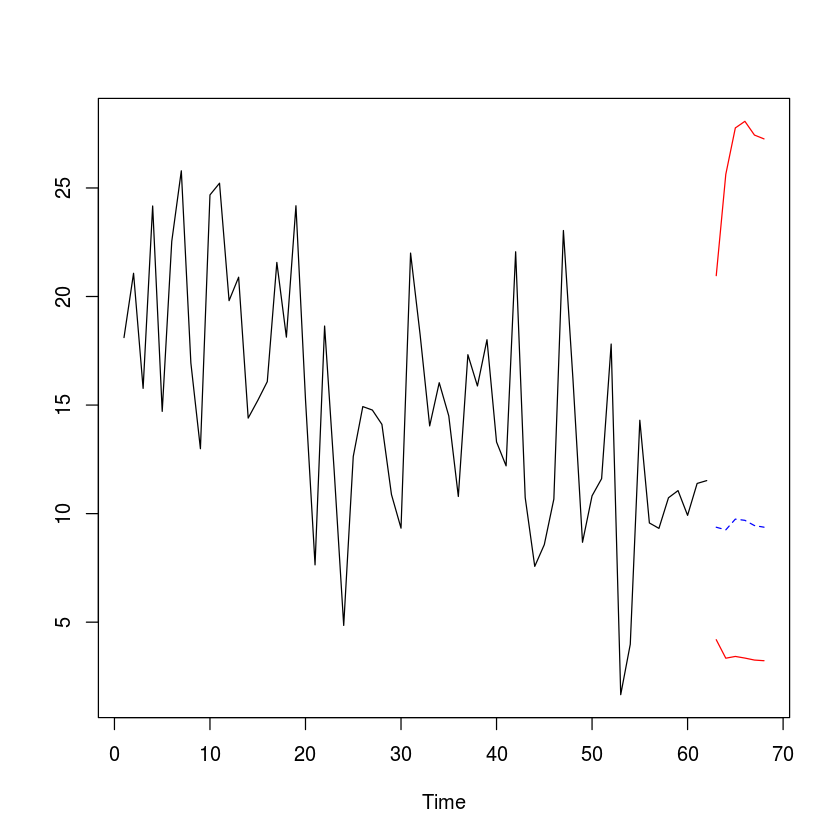

In [13]:
# Plot the prediction
par(mfrow=c(1,1))
temp=rep(NA,62)
tfore=as.ts(c(temp,tfore))
tfore.U=as.ts(c(temp,tfore.U))
tfore.L=as.ts(c(temp,tfore.L))
ts.plot(data.ts,tfore,tfore.U,tfore.L,lty=c(1,2,1,1),col=c(1,4,2,2))

# Conclusion

ARIMA model is a easy and powerful model, let us forecast accurately, but we have to measure carefully especially preparing the data. As spoken, R is a powerful calculator but not easy to develop programs, I will also practice the ARIMA model in the python in future.